In [43]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm

import patch_nr_paper_model
import utils_patch_nr_paper
from dataset.FastPatchExtractor import FastImageLoader
from regularisers import PatchNrRegulariser

In [44]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


Load the PatchNr flow model weights

In [45]:
patch_size = 6
model_weights = torch.load('patchNR/patchNR_weights/weights_material.pth', map_location=DEVICE)
model = patch_nr_paper_model.create_NF(num_layers=5, sub_net_size=512, dimension=patch_size**2)
model.load_state_dict(model_weights['net_state_dict'])
model.to(DEVICE)

ReversibleGraphNet(
  (module_list): ModuleList(
    (0): GLOWCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=18, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=36, bias=True)
      )
      (subnet2): Sequential(
        (0): Linear(in_features=18, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=36, bias=True)
      )
    )
    (1): PermuteRandom()
    (2): GLOWCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=18, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=36, bias=True)
      )
      (subnet2): Sequential(
        (0): Lin

In [46]:
def patch_nr_paper_regulariser(image, model, p_size=6, n_pad=40000):
    # This code belongs to the paper
    #
    # F. Altekrüger, A. Denker, P. Hagemann, J. Hertrich, P. Maass and G. Steidl (2023).
    # PatchNR: Learning from Very Few Images by Patch Normalizing Flow Regularization.
    # Inverse Problems, vol. 39, no. 6.
    input_im2pat = utils_patch_nr_paper.patch_extractor(patch_size=p_size, pad=False, center=False)
    pad_size = 4 #pad the image before extracting patches to avoid boundary effects
    pad = [pad_size]*4
    tmp = F.pad(image, pad, mode='reflect')
    fake_data = input_im2pat(tmp, n_pad)

    #patchNR
    pred_inv, log_det_inv = model(fake_data,rev=True)
    return torch.mean(torch.sum(pred_inv**2,dim=1)/2) - torch.mean(log_det_inv)

In [47]:
samples = 40000

In [48]:
#patch_nr_regulariser = PatchNrRegulariser(model, p_size=patch_size, sample_number=samples, padding=True, padding_size=16, device='cpu')

In [49]:
normalization = transforms.Compose([transforms.Normalize([0, ], [255., ])])
image_loader = FastImageLoader('data/material_pt_nr/validate.png', device=DEVICE, transform=normalization)
ground_truth = image_loader[0].to(DEVICE)

In [50]:
samples_amount = [i for i in range(1000, 150000, 10000)]
amount = 250
res = []
times = []
for sample_a in samples_amount:
    custom_regulariser = PatchNrRegulariser(model, p_size=patch_size, sample_number=sample_a, padding=True, padding_size=16, device=DEVICE)
    values = []
    start_time = time.time()
    for i in tqdm(range(250)):
        custom_val = custom_regulariser.evaluate(ground_truth)
        values.append(custom_val.item())
    end_time = time.time()
    values = torch.tensor(values)
    val_min = torch.min(values)
    val_mean = torch.mean(values)
    val_max = torch.max(values)
    res.append((val_min, val_mean, val_max))
    times.append(end_time-start_time)

100%|██████████| 250/250 [01:18<00:00,  3.18it/s]


Left plot of the mean and variance of the patchNR regulariser value for 250 evaluations of the validation image. Right plot of the time spend for the computation of the 250 evaluations. Range of the patch_amount was set to 1000-150000 with step-size of 10000 e.g. 15 evaluation pairs

In [77]:
val = torch.tensor(res, device='cpu').detach().numpy()
np.save(f'results/regulariser_eval/patch_nr_250_range_1000_150000_step_10000_min_max_mean.npy', val)
tim = torch.tensor(times, device='cpu').detach().numpy()
np.save(f'results/regulariser_eval/patch_nr_250_range_1000_150000_step_10000_time.npy', tim)


In [ ]:
saved_value = np.load(f'results/regulariser_eval/patch_nr_250_range_1000_150000_step_10000_min_max_mean.npy')
saved_time_values = np.load(f'results/regulariser_eval/patch_nr_250_range_1000_150000_step_10000_time.npy')

In [ ]:
mins, means, maxes = zip(*saved_value)
x = [i for i in range(1000, 150000, 10000)]

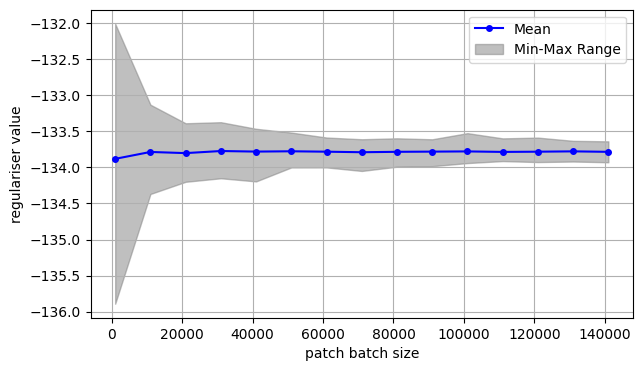

<Figure size 640x480 with 0 Axes>

In [78]:
plt.figure(figsize=(7, 4))
plt.plot(x, means, label='Mean', linestyle='-', marker='o', markersize=4, color='blue')
plt.fill_between(x, mins, maxes, color='gray', alpha=0.5, label='Min-Max Range')
#plt.axvline(x = 50000, color = 'g')
plt.legend()
plt.xlabel('patch batch size')
plt.ylabel('regulariser value')
plt.grid(True)
plt.show()
plt.savefig('images/min_max_mean_patch_nr_validate.png')

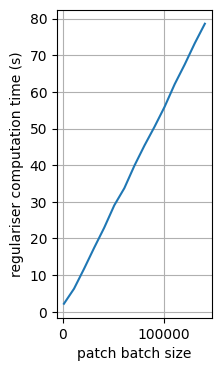

<Figure size 640x480 with 0 Axes>

In [79]:
plt.figure(figsize=(2, 4))
plt.plot(x, saved_time_values)
plt.grid()
plt.xlabel('patch batch size')
plt.ylabel('regulariser computation time (s)')
plt.show()
plt.savefig('images/min_max_mean_patch_nr_validate_time.png')